In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import norm

from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit.library import (
    IntegerComparator,
    WeightedAdder,
    LinearAmplitudeFunction,
)


from qiskit_aer.primitives import Sampler
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem

from qiskit_finance.circuit.library import (
    GaussianConditionalIndependenceModel as GCI,
)

import pennylane as qml

In [2]:
K = 5
n_z = K
z_max = 2
z_values = np.linspace(-z_max, z_max, 2**K)
p_zeros = [0.15, 0.25, 0.5, 0.11, 0.32]
rhos = [0.1, 0.05, 0.08, 0.23, 0.08]
lgd = [1, 2, 3, 4, 2]
alpha = 0.05

In [3]:
u = GCI(n_z, z_max, p_zeros, rhos)

In [4]:
binary_probabilities_list = []
for i in range(5):
    u_measure = u.measure_all(inplace=False)
    sampler = Sampler()
    job = sampler.run(u_measure)
    binary_probabilities = job.result().quasi_dists[0].binary_probabilities()
    binary_probabilities_list.append(binary_probabilities)

In [5]:
market_data = []

for j in range(5):
    market_fixed_data = {}
    p_z = np.zeros(2**n_z)
    p_default = np.zeros(K)
    values = []
    probabilities = []
    num_qubits = u.num_qubits
    binary_probabilities = binary_probabilities_list[j]

    for i, prob in binary_probabilities.items():
        # extract value of Z and corresponding probability
        i_normal = int(i[-n_z:], 2)
        p_z[i_normal] += prob

        # determine overall default probability for k
        loss = 0
        for k in range(K):
            if i[K - k - 1] == "1":
                p_default[k] += prob
                loss += lgd[k]

        values += [loss]
        probabilities += [prob]

    values = np.array(values)
    probabilities = np.array(probabilities)

    exact_expected_loss = np.dot(values, probabilities)
    losses = np.sort(np.unique(values))
    pdf = np.zeros(len(losses))
    for i, v in enumerate(losses):
        pdf[i] += sum(probabilities[values == v])
    cdf = np.cumsum(pdf)

    i_var = np.argmax(cdf >= 1 - alpha)
    exact_var = losses[i_var]
    exact_cvar = np.dot(pdf[(i_var + 1) :], losses[(i_var + 1) :]) / sum(
        pdf[(i_var + 1) :]
    )

    # Market Data
    market_fixed_data["p_z"] = p_z
    market_fixed_data["pdf"] = pdf
    market_fixed_data["losses"] = losses
    market_fixed_data["run_num"] = j
    market_fixed_data["seed"] = np.random.randint(50, 100)
    market_fixed_data["cdf"] = cdf

    # Emperical Calculations Answers
    market_fixed_data["Emperical Calculations"] = {
        "expected_loss": exact_expected_loss,
        "var": exact_var,
        "cvar": exact_cvar,
        "probability": cdf[exact_var],
    }

    market_data.append(market_fixed_data)

In [6]:
for i, run_data in enumerate(market_data):
    data = run_data.get("Emperical Calculations")
    print(f"Market conditions for p_z_{i}")
    print(
        "Expected Loss E[L]:                %.4f" % data.get("expected_loss")
    )
    print("Value at Risk VaR[L]:              %.4f" % data.get("var"))
    print("P[L <= VaR[L]]:                    %.4f" % data.get("probability"))
    print("Conditional Value at Risk CVaR[L]: %.4f" % data.get("cvar"))

    print("#" * 20)

Market conditions for p_z_0
Expected Loss E[L]:                3.1133
Value at Risk VaR[L]:              7.0000
P[L <= VaR[L]]:                    0.9531
Conditional Value at Risk CVaR[L]: 8.9792
####################
Market conditions for p_z_1
Expected Loss E[L]:                3.2793
Value at Risk VaR[L]:              7.0000
P[L <= VaR[L]]:                    0.9541
Conditional Value at Risk CVaR[L]: 9.2766
####################
Market conditions for p_z_2
Expected Loss E[L]:                3.0244
Value at Risk VaR[L]:              8.0000
P[L <= VaR[L]]:                    0.9658
Conditional Value at Risk CVaR[L]: 9.5143
####################
Market conditions for p_z_3
Expected Loss E[L]:                3.2588
Value at Risk VaR[L]:              8.0000
P[L <= VaR[L]]:                    0.9609
Conditional Value at Risk CVaR[L]: 9.5000
####################
Market conditions for p_z_4
Expected Loss E[L]:                3.1318
Value at Risk VaR[L]:              7.0000
P[L <= VaR[L]]:     

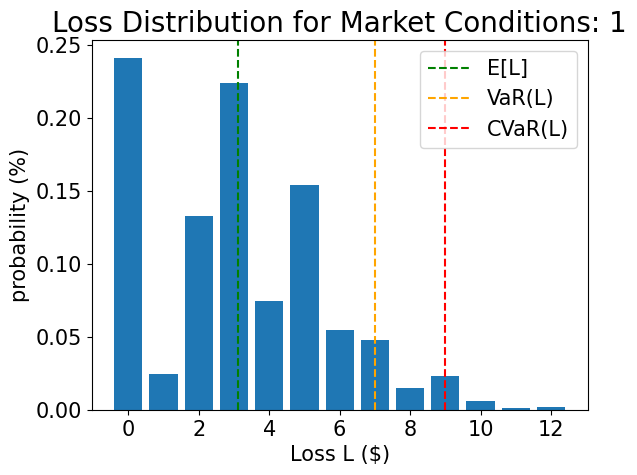

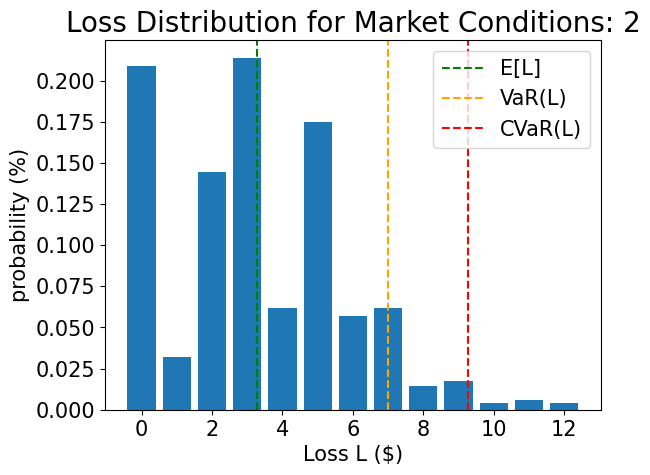

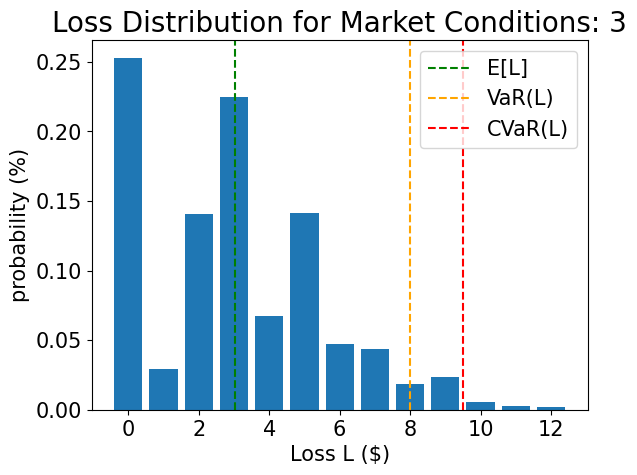

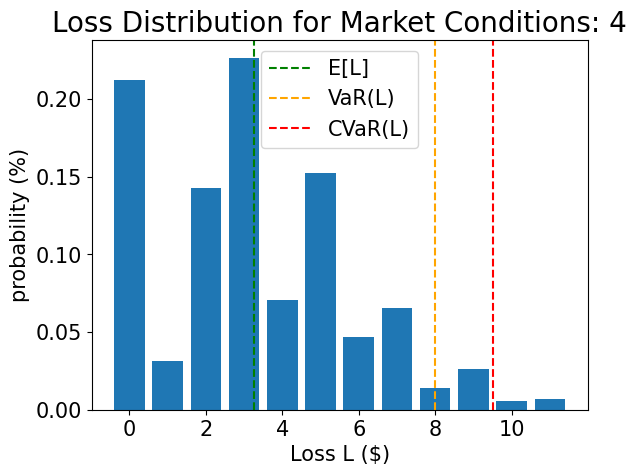

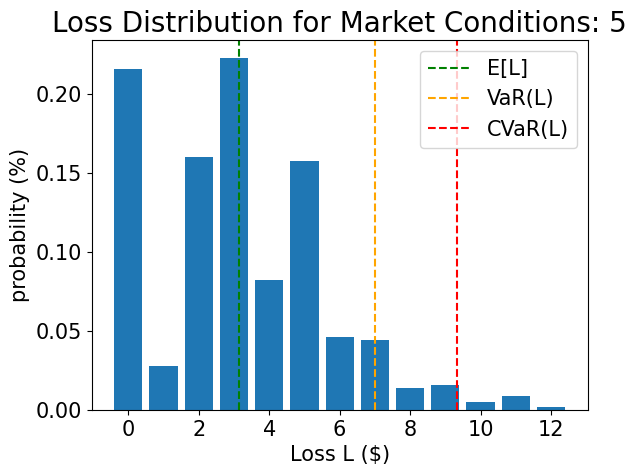

In [7]:
for i, market_data_run in enumerate(market_data):
    losses = market_data_run.get("losses")
    pdf = market_data_run.get("pdf")
    expected_loss = market_data_run.get("Emperical Calculations").get(
        "expected_loss"
    )
    var = market_data_run.get("Emperical Calculations").get("var")
    cvar = market_data_run.get("Emperical Calculations").get("cvar")

    plt.bar(losses, pdf)
    plt.axvline(expected_loss, color="green", linestyle="--", label="E[L]")
    plt.axvline(var, color="orange", linestyle="--", label="VaR(L)")
    plt.axvline(cvar, color="red", linestyle="--", label="CVaR(L)")
    plt.legend(fontsize=15)
    plt.xlabel("Loss L ($)", size=15)
    plt.ylabel("probability (%)", size=15)
    plt.title(f"Loss Distribution for Market Conditions: {i+1}", size=20)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.show()

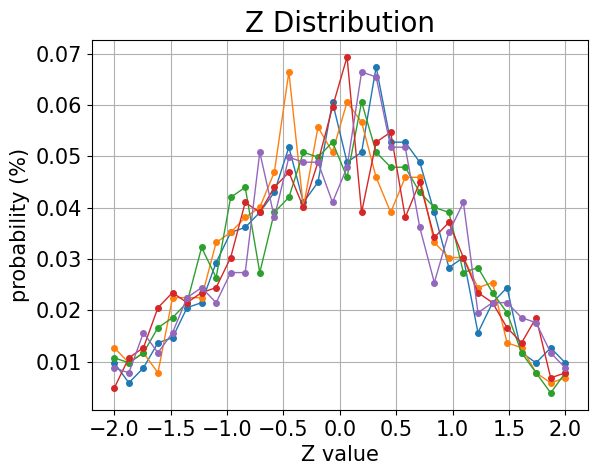

In [8]:
plt.plot(z_values, market_data[0].get("p_z"), "o-", linewidth=1, markersize=4)
plt.plot(z_values, market_data[1].get("p_z"), "o-", linewidth=1, markersize=4)
plt.plot(z_values, market_data[2].get("p_z"), "o-", linewidth=1, markersize=4)
plt.plot(z_values, market_data[3].get("p_z"), "o-", linewidth=1, markersize=4)
plt.plot(z_values, market_data[4].get("p_z"), "o-", linewidth=1, markersize=4)
plt.grid()
plt.xlabel("Z value", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Z Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

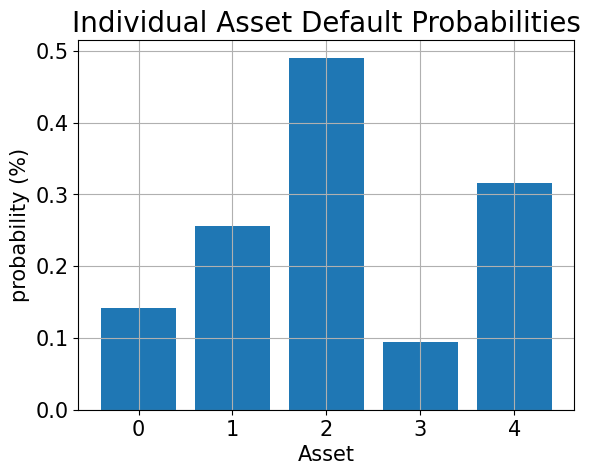

In [9]:
plt.bar(range(K), p_default)
plt.xlabel("Asset", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Individual Asset Default Probabilities", size=20)
plt.xticks(range(K), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

# Classical Simulation

In [10]:
rhos_np = np.array(rhos)
lgd_np = np.array(lgd)
probit_thresholds = norm.ppf(p_zeros)
number_simulations = 10000

In [11]:
def simulate_potfolio_losses_classsic(p_z):
    losses = np.zeros(number_simulations)

    for i in range(number_simulations):
        z = np.random.choice(z_values, p=p_z)
        F = np.random.normal(0, 1, K)
        credit_events = (np.sqrt(rhos_np) * z) + (np.sqrt(1 - rhos_np) * F)
        defaults = credit_events < probit_thresholds
        losses[i] = np.sum(defaults * lgd_np)

    return losses


def calculate_var_cvar(losses, alpha=0.05):
    e_loss = np.mean(losses)
    var = np.percentile(losses, (1 - alpha) * 100)
    cvar = np.mean(losses[losses >= var])
    return e_loss, var, cvar

In [12]:
for i, market_data_run in enumerate(market_data):
    classical_losses = simulate_potfolio_losses_classsic(
        market_data_run.get("p_z")
    )
    classical_expected_losses, classical_var, classical_cvar = (
        calculate_var_cvar(losses=classical_losses)
    )
    market_data[i]["Classical Monte Carlo"] = {
        "expected_loss": classical_expected_losses,
        "var": classical_var,
        "cvar": classical_cvar,
        "probability": market_data_run.get("cdf")[int(classical_var)],
    }

In [13]:
for i, run_data in enumerate(market_data):
    print(
        "Expected Loss E[L]:       %.4f"
        % run_data.get("Emperical Calculations", {}).get("expected_loss")
    )
    print(
        "Expected Loss E[L] CMC:   %.4f"
        % run_data.get("Classical Monte Carlo", {}).get("expected_loss")
    )
    print("#" * 25)

    print(
        "Exact Value at Risk:     %2d"
        % run_data.get("Emperical Calculations", {}).get("var")
    )
    print(
        "CMC Value at Risk:       %2d"
        % run_data.get("Classical Monte Carlo", {}).get("var")
    )

    print("#" * 25)

    print(
        "Exact CVaR:    \t%.4f"
        % run_data.get("Emperical Calculations", {}).get("cvar")
    )
    print(
        "CMC CVaR:      \t%.4f"
        % run_data.get("Classical Monte Carlo", {}).get("cvar")
    )

    print("*" * 50)

Expected Loss E[L]:       3.1133
Expected Loss E[L] CMC:   3.1450
#########################
Exact Value at Risk:      7
CMC Value at Risk:        7
#########################
Exact CVaR:    	8.9792
CMC CVaR:      	7.9502
**************************************************
Expected Loss E[L]:       3.2793
Expected Loss E[L] CMC:   3.2668
#########################
Exact Value at Risk:      7
CMC Value at Risk:        8
#########################
Exact CVaR:    	9.2766
CMC CVaR:      	9.0972
**************************************************
Expected Loss E[L]:       3.0244
Expected Loss E[L] CMC:   3.1950
#########################
Exact Value at Risk:      8
CMC Value at Risk:        8
#########################
Exact CVaR:    	9.5143
CMC CVaR:      	9.1975
**************************************************
Expected Loss E[L]:       3.2588
Expected Loss E[L] CMC:   3.2221
#########################
Exact Value at Risk:      8
CMC Value at Risk:        8
#########################
Exact CVaR:  

# Quantum Amplitude Estimation

## Expected Loss

In [14]:
agg = WeightedAdder(n_z + K, [0] * n_z + lgd)

In [15]:
breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum(lgd)
c_approx = 0.25

objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slope=slopes,
    offset=offsets,
    # max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2**agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

In [16]:
# define the registers for convenience and readability
qr_state = QuantumRegister(u.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
qr_obj = QuantumRegister(1, "objective")
qr_control = QuantumRegister(1, "control")

# define the circuit
state_preparation = QuantumCircuit(
    qr_state, qr_obj, qr_sum, qr_carry, qr_control, name="A"
)

# load the random variable
state_preparation.append(u.to_gate(), qr_state)

# aggregate
state_preparation.append(
    agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:]
)

# # linear objective function
state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])

# # uncompute aggregation
state_preparation.append(
    agg.to_gate().inverse(),
    qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:],
)

In [17]:
state_preparation.draw()

┌───────┐┌─────────┐      ┌────────────┐
  state_0: ┤0      ├┤0        ├──────┤0           ├
           │       ││         │      │            │
  state_1: ┤1      ├┤1        ├──────┤1           ├
           │       ││         │      │            │
  state_2: ┤2      ├┤2        ├──────┤2           ├
           │       ││         │      │            │
  state_3: ┤3      ├┤3        ├──────┤3           ├
           │       ││         │      │            │
  state_4: ┤4      ├┤4        ├──────┤4           ├
           │  P(X) ││         │      │            │
  state_5: ┤5      ├┤5        ├──────┤5           ├
           │       ││         │      │            │
  state_6: ┤6      ├┤6        ├──────┤6           ├
           │       ││         │      │            │
  state_7: ┤7      ├┤7        ├──────┤7           ├
           │       ││         │      │            │
  state_8: ┤8      ├┤8        ├──────┤8           ├
           │       ││         │      │            │
  state_9: ┤9      ├┤9  adder ├──────┤9  adder_dg ├
           └───────┘│         │┌────┐│            │
objective: ─────────┤         ├┤4   ├┤            ├
                    │         ││    ││            │
    sum_0: ─────────┤10       ├┤0   ├┤10          ├
                    │         ││    ││            │
    sum_1: ─────────┤11       ├┤1 F ├┤11          ├
                    │         ││    ││            │
    sum_2: ─────────┤12       ├┤2   ├┤12          ├
                    │         ││    ││            │
    sum_3: ─────────┤13       ├┤3   ├┤13          ├
                    │         │└────┘│            │
  carry_0: ─────────┤14       ├──────┤14          ├
                    │         │      │            │
  carry_1: ─────────┤15       ├──────┤15          ├
                    │         │      │            │
  carry_2: ─────────┤16       ├──────┤16          ├
                    │         │      │            │
  control: ─────────┤17       ├──────┤17          ├
                    └─────────┘      └────────────┘

In [18]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

### Validation Run - Direct Simulation

In [19]:
value = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1) :][0] == "1":
        value += prob

print(
    "Exact Expected Loss:   %.4f"
    % market_data[0].get("Emperical Calculations", {}).get("expected_loss")
)
print("Exact Operator Value:  %.4f" % value)
print("Mapped Operator value: %.4f" % objective.post_processing(value))

Exact Expected Loss:   3.1133
Exact Operator Value:  0.4033
Mapped Operator value: 3.0457


### Quantum Amplitude Estimation

In [20]:
epsilon = 0.01
alpha = 0.05

for i, market_data_run in enumerate(market_data):
    problem = EstimationProblem(
        state_preparation=state_preparation,
        objective_qubits=[len(qr_state)],
        post_processing=objective.post_processing,
    )
    # construct amplitude estimation
    ae = IterativeAmplitudeEstimation(
        epsilon_target=epsilon,
        alpha=alpha,
        sampler=Sampler(
            run_options={"shots": 100, "seed": market_data_run.get("seed")}
        ),
    )
    result = ae.estimate(problem)

    # print results
    conf_int = np.array(result.confidence_interval_processed)
    qc_expected_loss = result.estimation_processed

    market_data[i]["Quantum Amplitude Estimation"] = {
        "expected_loss": qc_expected_loss,
        "var": None,
        "cvar": None,
        "probability": None,
    }

### Cumulative Distribution Function

In [21]:
x_eval = 5

comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)

In [22]:
comparator.draw()

┌──────┐
state_0: ┤0     ├
         │      │
state_1: ┤1     ├
         │      │
state_2: ┤2     ├
         │      │
state_3: ┤3     ├
         │  cmp │
compare: ┤4     ├
         │      │
 a105_0: ┤5     ├
         │      │
 a105_1: ┤6     ├
         │      │
 a105_2: ┤7     ├
         └──────┘

In [23]:
def get_cdf_circuit(x_eval):
    # define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, "state")
    qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
    qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
    qr_obj = QuantumRegister(1, "objective")
    qr_compare = QuantumRegister(1, "compare")
    qr_control = QuantumRegister(1, "control")

    # define the circuit
    state_preparation = QuantumCircuit(
        qr_state, qr_obj, qr_sum, qr_carry, qr_control, name="A"
    )

    # load the random variable
    state_preparation.append(u, qr_state)

    # aggregate
    state_preparation.append(
        agg, qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:]
    )

    # comparator objective function
    comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
    state_preparation.append(comparator, qr_sum[:] + qr_obj[:] + qr_carry[:])

    # uncompute aggregation
    state_preparation.append(
        agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:]
    )

    return state_preparation

In [24]:
state_preparation = get_cdf_circuit(x_eval)

In [25]:
state_preparation.draw()

┌───────┐┌─────────┐        ┌────────────┐
  state_0: ┤0      ├┤0        ├────────┤0           ├
           │       ││         │        │            │
  state_1: ┤1      ├┤1        ├────────┤1           ├
           │       ││         │        │            │
  state_2: ┤2      ├┤2        ├────────┤2           ├
           │       ││         │        │            │
  state_3: ┤3      ├┤3        ├────────┤3           ├
           │       ││         │        │            │
  state_4: ┤4      ├┤4        ├────────┤4           ├
           │  P(X) ││         │        │            │
  state_5: ┤5      ├┤5        ├────────┤5           ├
           │       ││         │        │            │
  state_6: ┤6      ├┤6        ├────────┤6           ├
           │       ││         │        │            │
  state_7: ┤7      ├┤7        ├────────┤7           ├
           │       ││         │        │            │
  state_8: ┤8      ├┤8        ├────────┤8           ├
           │       ││         │        │            │
  state_9: ┤9      ├┤9  adder ├────────┤9  adder_dg ├
           └───────┘│         │┌──────┐│            │
objective: ─────────┤         ├┤4     ├┤            ├
                    │         ││      ││            │
    sum_0: ─────────┤10       ├┤0     ├┤10          ├
                    │         ││      ││            │
    sum_1: ─────────┤11       ├┤1     ├┤11          ├
                    │         ││      ││            │
    sum_2: ─────────┤12       ├┤2     ├┤12          ├
                    │         ││  cmp ││            │
    sum_3: ─────────┤13       ├┤3     ├┤13          ├
                    │         ││      ││            │
  carry_0: ─────────┤14       ├┤5     ├┤14          ├
                    │         ││      ││            │
  carry_1: ─────────┤15       ├┤6     ├┤15          ├
                    │         ││      ││            │
  carry_2: ─────────┤16       ├┤7     ├┤16          ├
                    │         │└──────┘│            │
  control: ─────────┤17       ├────────┤17          ├
                    └─────────┘        └────────────┘

In [26]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [27]:
var_prob = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1) :][0] == "1":
        var_prob += prob

print("Operator CDF(%s)" % x_eval + " = %.4f" % var_prob)
print("Exact    CDF(%s)" % x_eval + " = %.4f" % cdf[x_eval])

Operator CDF(5) = 0.8408
Exact    CDF(5) = 0.8652


In [28]:
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=state_preparation, objective_qubits=[len(qr_state)]
)
# construct amplitude estimation
ae_cdf = IterativeAmplitudeEstimation(
    epsilon_target=epsilon,
    alpha=alpha,
    sampler=Sampler(
        run_options={"shots": 100, "seed": market_data[0].get("seed")}
    ),
)
result_cdf = ae_cdf.estimate(problem)

# print results
conf_int = np.array(result_cdf.confidence_interval)
print("Exact value:    \t%.4f" % market_data[0].get("cdf")[x_eval])
print("Estimated value:\t%.4f" % result_cdf.estimation)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact value:    	0.8506
Estimated value:	0.8518
Confidence interval: 	[0.8466, 0.8571]


### Value At Risk

In [29]:
def run_iae_for_cdf(x_eval, seed, epsilon=0.01, alpha=0.05):

    # construct amplitude estimation
    state_preparation = get_cdf_circuit(x_eval)
    problem = EstimationProblem(
        state_preparation=state_preparation, objective_qubits=[len(qr_state)]
    )
    ae_var = IterativeAmplitudeEstimation(
        epsilon_target=epsilon,
        alpha=alpha,
        sampler=Sampler(run_options={"shots": 100, "seed": seed}),
    )
    result_var = ae_var.estimate(problem)

    return result_var.estimation

In [30]:
def bisection_search(
    objective,
    target_value,
    low_level,
    high_level,
    low_value=None,
    high_value=None,
):
    """
    Determines the smallest level such that the objective value is still larger than the target
    :param objective: objective function
    :param target: target value
    :param low_level: lowest level to be considered
    :param high_level: highest level to be considered
    :param low_value: value of lowest level (will be evaluated if set to None)
    :param high_value: value of highest level (will be evaluated if set to None)
    :return: dictionary with level, value, num_eval
    """
    num_eval = 0
    if low_value is None:
        low_value = objective(low_level)
        num_eval += 1
    if high_value is None:
        high_value = objective(high_level)
        num_eval += 1

    if low_value > target_value:
        return {
            "level": low_level,
            "value": low_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif low_value == target_value:
        return {
            "level": low_level,
            "value": low_value,
            "num_eval": num_eval,
            "comment": "success",
        }

    if high_value < target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif high_value == target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "success",
        }

    while high_level - low_level > 1:

        level = int(np.round((high_level + low_level) / 2.0))
        num_eval += 1
        value = objective(level)

        if value >= target_value:
            high_level = level
            high_value = value
        else:
            low_level = level
            low_value = value

    return {
        "level": high_level,
        "value": high_value,
        "num_eval": num_eval,
        "comment": "success",
    }

In [31]:
for i, market_data_run in enumerate(market_data):
    objective = lambda x: run_iae_for_cdf(x, market_data_run.get("seed"))
    bisection_result = bisection_search(
        objective,
        1 - alpha,
        min(losses) - 1,
        max(losses),
        low_value=0,
        high_value=1,
    )
    qc_var = bisection_result["level"]
    market_data[i]["Quantum Amplitude Estimation"]["var"] = qc_var
    market_data[i]["Quantum Amplitude Estimation"]["probability"] = (
        market_data_run.get("cdf")[qc_var]
    )
    market_data[i]["bisection_result"] = bisection_result

### Conditional Value at Risk

In [32]:
for i, market_data_run in enumerate(market_data):
    qc_var = market_data_run.get("Quantum Amplitude Estimation").get("var")
    breakpoints = [0, qc_var]
    slopes = [0, 1]
    offsets = [0, 0]  # subtract VaR and add it later to the estimate
    f_min = 0
    f_max = 3 - qc_var
    c_approx = 0.25

    cvar_objective = LinearAmplitudeFunction(
        agg.num_sum_qubits,
        slopes,
        offsets,
        domain=(0, 2**agg.num_sum_qubits - 1),
        image=(f_min, f_max),
        rescaling_factor=c_approx,
        breakpoints=breakpoints,
    )

    market_data[i]["cvar_objective"] = cvar_objective

In [33]:
cvar_objective.draw()

┌────┐
q1070_0: ┤0   ├
         │    │
q1070_1: ┤1   ├
         │    │
q1070_2: ┤2   ├
         │    │
q1070_3: ┤3   ├
         │    │
  q1071: ┤4 F ├
         │    │
 a600_0: ┤5   ├
         │    │
 a600_1: ┤6   ├
         │    │
 a600_2: ┤7   ├
         │    │
 a600_3: ┤8   ├
         └────┘

In [34]:
for i, market_data_run in enumerate(market_data):
    cvar_objective = market_data_run.get("cvar_objective")
    qr_state = QuantumRegister(u.num_qubits, "state")
    qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
    qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
    qr_obj = QuantumRegister(1, "objective")
    qr_work = QuantumRegister(
        cvar_objective.num_ancillas - len(qr_carry), "work"
    )
    qr_control = QuantumRegister(1, "control")

    # define the circuit
    state_preparation = QuantumCircuit(
        qr_state, qr_obj, qr_sum, qr_carry, qr_work, qr_control, name="A"
    )

    # load the random variable
    state_preparation.append(u, qr_state)

    # aggregate
    state_preparation.append(
        agg, qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:]
    )

    # linear objective function
    state_preparation.append(
        cvar_objective, qr_sum[:] + qr_obj[:] + qr_carry[:] + qr_work[:]
    )

    # uncompute aggregation
    state_preparation.append(
        agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:]
    )

    market_data[i]["state_preparation"] = state_preparation

In [35]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [36]:
value = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1)] == "1":
        value += prob

# normalize and add VaR to estimate
value = cvar_objective.post_processing(value)
d = 1.0 - market_data[0].get("bisection_result")["value"]
v = value / d if d != 0 else 0
normalized_value = v + market_data[0].get("Quantum Amplitude Estimation").get(
    "var"
)

print(
    "Exact CVaR:     %.4f"
    % market_data[0].get("Emperical Calculations").get("cvar")
)
print("Estimated CVaR: %.4f" % normalized_value)

Exact CVaR:     8.9792
Estimated CVaR: 2.0337


In [37]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

for i, market_data_run in enumerate(market_data):
    problem = EstimationProblem(
        state_preparation=market_data_run.get("state_preparation"),
        objective_qubits=[len(qr_state)],
        post_processing=market_data_run.get("cvar_objective").post_processing,
    )
    ae_cvar = IterativeAmplitudeEstimation(
        epsilon_target=epsilon,
        alpha=alpha,
        sampler=Sampler(
            run_options={"shots": 100, "seed": market_data_run.get("seed")}
        ),
    )
    result_cvar = ae_cvar.estimate(problem)

    d = 1.0 - market_data_run.get("bisection_result")["value"]
    v = result_cvar.estimation_processed / d if d != 0 else 0
    qc_cvar = v + qc_var
    market_data[i]["Quantum Amplitude Estimation"]["cvar"] = qc_cvar

### PennyLane Quantun Monte Carlo - Phase Estimation

In [38]:
M = 2 ** K
n = 13
N = 2 ** n

def func(z):
    F = np.random.normal(0, 1, 1) # Asset specific factor
    credit_events = (
        (np.sqrt(rhos[i]) * z_values[z]) + 
        (np.sqrt(1 - rhos[i]) * F)
    )

    return credit_events < probit_thresholds[i]

for j, market_data_run in enumerate(market_data):
    losses = []
    
    for _ in range(20):
        e_L = []
        for i in range(K):
            target_wires = range(K + 1)
            estimation_wires = range(K + 1, n + K + 1)
            dev = qml.device("default.qubit", wires=(n + K + 1), shots = 50)

            @qml.qnode(dev)
            def circuit():
                qml.templates.QuantumMonteCarlo(
                    market_data_run.get("p_z"),
                    func,
                    target_wires=target_wires,
                    estimation_wires=estimation_wires,
                )
                return qml.probs(estimation_wires)
        
            phase_estimated = np.argmax(circuit()[:int(N / 2)]) / N

            e_L.append(((1 - np.cos(np.pi * phase_estimated)) / 2) * lgd[i])
        losses.append(sum(e_L))
        
    e_loss, var, cvar = calculate_var_cvar(np.array(losses))
    market_data[j]["Quantum Monte Carlo by PennyLane"] = { 
    "expected_loss": e_loss,
    "var": var,
    "cvar": cvar,
    "probability": market_data_run.get("cdf")[int(var)]}

### Results Comparison

In [39]:
def abs_error(m1,m2):
    return abs(m1 - m2)

def relative_error(m1,m2):
    return abs_error(m1,m2)/abs(m1)

def mse(m1,m2):
    return (m2 - m1) ** 2

In [40]:

table_data =[]
table_data_el = []
table_data_var = []
table_data_cvar = []
for market_data_run in market_data:
    run_number = market_data_run.get("run_num")
    exact_expected_loss = market_data_run.get("Emperical Calculations").get("expected_loss")
    exact_var = market_data_run.get("Emperical Calculations").get("var")
    exact_cvar = market_data_run.get("Emperical Calculations").get("cvar")
    exact_probablity = market_data_run.get("Emperical Calculations").get("probability")
    
    calc_list = ["Emperical Calculations", "Classical Monte Carlo", "Quantum Amplitude Estimation", "Quantum Monte Carlo by PennyLane"]
    # calc_list = ["Emperical Calculations", "Quantum Monte Carlo by PennyLane"]
    for calculation in calc_list:
        data = market_data_run.get(calculation)
        table_data.append({"Name" : calculation, "Market Conditions": run_number, "Expected Loss": data.get("expected_loss"), "VaR": data.get("var"), "CVaR": data.get("cvar"), "Probability": data.get("probability")})
        
        table_data_el.append({"Name": calculation, "Market Conditions": run_number, "Expected Loss": data.get("expected_loss"), "Absolute Error": abs_error(exact_expected_loss, data.get("expected_loss")), "Relative Error": relative_error(exact_expected_loss, data.get("expected_loss")), "MSE": mse(exact_expected_loss, data.get("expected_loss"))})

        table_data_var.append({"Name": calculation, "Market Conditions": run_number, "VaR": data.get("var"), "Absolute Error": abs_error(exact_var, data.get("var")), "Relative Error": relative_error(exact_var, data.get("var")), "MSE": mse(exact_var, data.get("var"))})
        
        table_data_cvar.append({"Name": calculation, "Market Conditions": run_number, "CVaR": data.get("cvar"), "Absolute Error": abs_error(exact_cvar, data.get("cvar")), "Relative Error": relative_error(exact_cvar, data.get("cvar")), "MSE": mse(exact_cvar, data.get("cvar"))})

    
        
df_table = pd.DataFrame(table_data)
df_table_el = pd.DataFrame(table_data_el)
df_table_var = pd.DataFrame(table_data_var)
df_table_cvar = pd.DataFrame(table_data_cvar)

In [41]:
print(df_table.sort_values(["Name", "Market Conditions"]))

print("\n")

print(df_table_el.sort_values(["Name", "Market Conditions"]))

print("\n")

print(df_table_var.sort_values(["Name", "Market Conditions"]))

print("\n")

print(df_table_cvar.sort_values(["Name", "Market Conditions"]))

# print("\n")

                                Name  Market Conditions  Expected Loss  \
1              Classical Monte Carlo                  0       3.145000   
5              Classical Monte Carlo                  1       3.266800   
9              Classical Monte Carlo                  2       3.195000   
13             Classical Monte Carlo                  3       3.222100   
17             Classical Monte Carlo                  4       3.110900   
0             Emperical Calculations                  0       3.113281   
4             Emperical Calculations                  1       3.279297   
8             Emperical Calculations                  2       3.024414   
12            Emperical Calculations                  3       3.258789   
16            Emperical Calculations                  4       3.131836   
2       Quantum Amplitude Estimation                  0       1.695595   
6       Quantum Amplitude Estimation                  1       3.226851   
10      Quantum Amplitude Estimation  

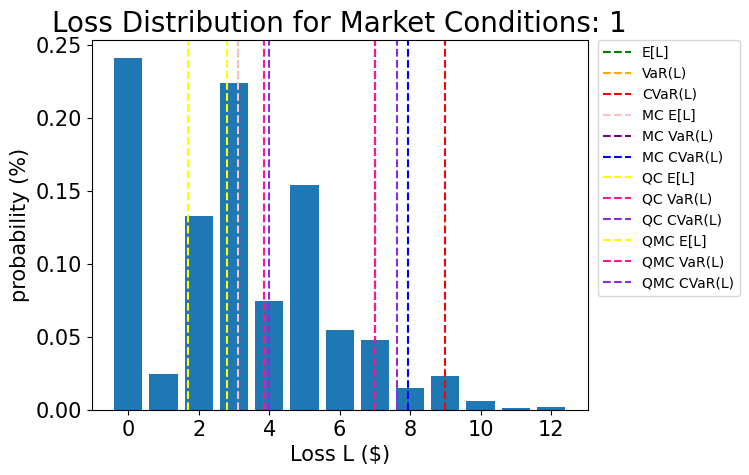

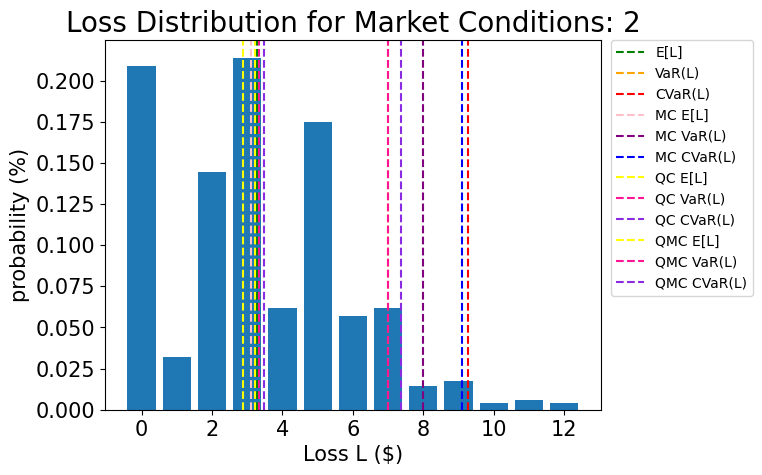

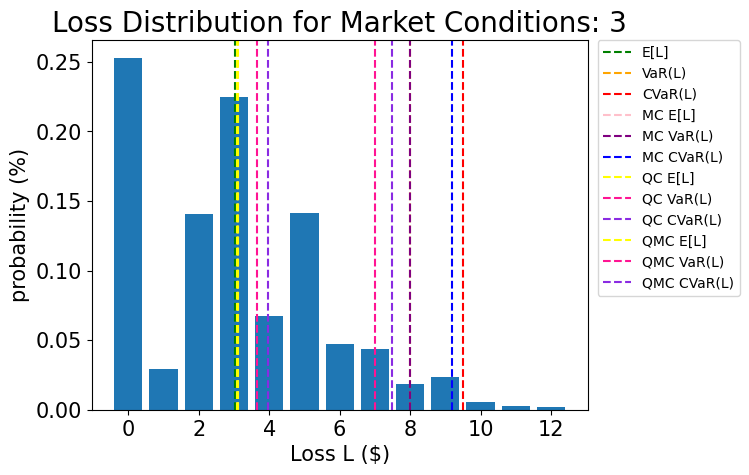

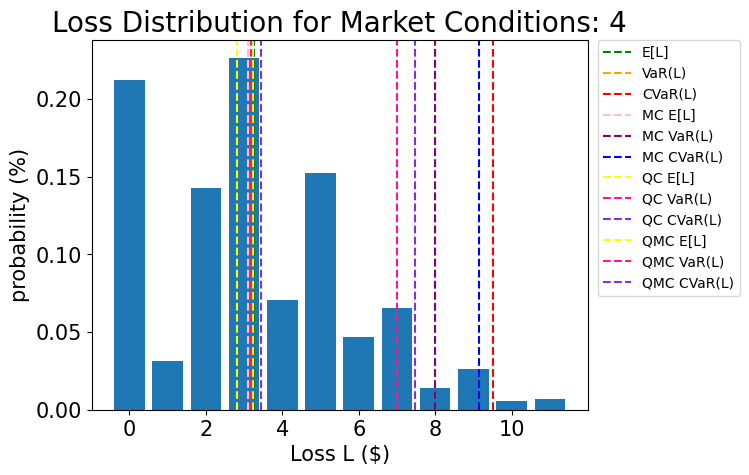

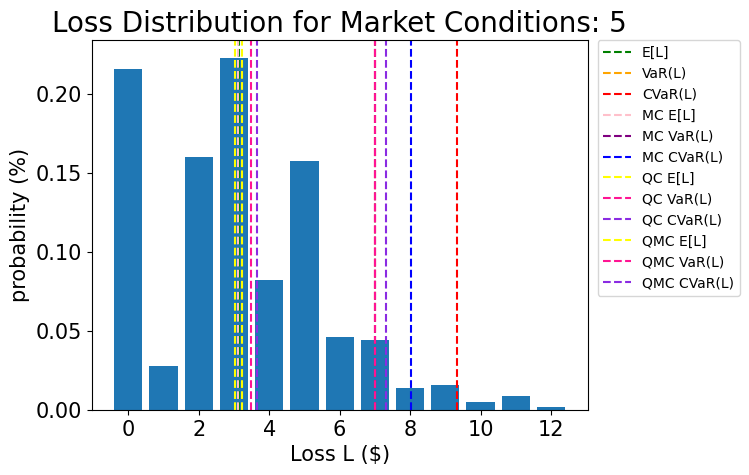

In [42]:
for i, market_data_run in enumerate(market_data):
    losses = market_data_run.get("losses")
    pdf = market_data_run.get("pdf")
    
    exact_expected_loss = market_data_run.get("Emperical Calculations").get("expected_loss")
    exact_var = market_data_run.get("Emperical Calculations").get("var")
    exact_cvar = market_data_run.get("Emperical Calculations").get("cvar")
    
    classical_expected_loss = market_data_run.get("Classical Monte Carlo").get("expected_loss")
    classical_var = market_data_run.get("Classical Monte Carlo").get("var")
    classical_cvar = market_data_run.get("Classical Monte Carlo").get("cvar")
    
    qc_expected_loss = market_data_run.get("Quantum Amplitude Estimation").get("expected_loss")
    qc_var = market_data_run.get("Quantum Amplitude Estimation").get("var")
    qc_cvar = market_data_run.get("Quantum Amplitude Estimation").get("cvar")
    
    qmc_expected_loss = market_data_run.get("Quantum Monte Carlo by PennyLane").get("expected_loss")
    qmc_var = market_data_run.get("Quantum Monte Carlo by PennyLane").get("var")
    qmc_cvar = market_data_run.get("Quantum Monte Carlo by PennyLane").get("cvar")
    
    plt.bar(losses, pdf)

    plt.axvline(exact_expected_loss, color="green", linestyle="--", label="E[L]")
    plt.axvline(exact_var, color="orange", linestyle="--", label="VaR(L)")
    plt.axvline(exact_cvar, color="red", linestyle="--", label="CVaR(L)")

    plt.axvline(classical_expected_losses, color="pink", linestyle="--", label="MC E[L]")
    plt.axvline(classical_var, color="purple", linestyle="--", label="MC VaR(L)")
    plt.axvline(classical_cvar, color="blue", linestyle="--", label="MC CVaR(L)")

    plt.axvline(qc_expected_loss, color="yellow", linestyle="--", label="QC E[L]")
    plt.axvline(qc_var, color="deeppink", linestyle="--", label="QC VaR(L)")
    plt.axvline(qc_cvar, color="blueviolet", linestyle="--", label="QC CVaR(L)")
    
    plt.axvline(qmc_expected_loss, color="yellow", linestyle="--", label="QMC E[L]")
    plt.axvline(qmc_var, color="deeppink", linestyle="--", label="QMC VaR(L)")
    plt.axvline(qmc_cvar, color="blueviolet", linestyle="--", label="QMC CVaR(L)")

    plt.legend(fontsize=15)
    plt.xlabel("Loss L ($)", size=15)
    plt.ylabel("probability (%)", size=15)
    plt.title(f"Loss Distribution for Market Conditions: {i+1}", size=20)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.show()